In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import datetime
from IPython.display import display

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow as tf
import kerastuner

# LOAD DATA FROM CSV FILE

In [2]:
def load_data(csv_path):
    return pd.read_csv(csv_path)


target_col = "amount"
date = "txn_date"
period = "D"

stationary_df = load_data("supervised_model.csv")
stationary_df.head()

,txn_date,is_stationary,amount,amount_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
0,2021-02-24,False,2705.25,-747.55,-747.55,1570.30,-99.00,-344.05,574.80,-364.25,0.00
1,2021-02-25,False,2878.30,173.05,173.05,-747.55,1570.30,-99.00,-344.05,574.80,-364.25
2,2021-02-26,False,2227.05,-651.25,-651.25,173.05,-747.55,1570.30,-99.00,-344.05,574.80
3,2021-02-27,False,2911.50,684.45,684.45,-651.25,173.05,-747.55,1570.30,-99.00,-344.05
4,2021-02-28,False,2122.75,-788.75,-788.75,684.45,-651.25,173.05,-747.55,1570.30,-99.00


# UNIVARIANT FORECAST WITH LSTM

In [3]:
dataset = stationary_df.copy()
dataset = dataset[[target_col + "_diff"]]

display(dataset.head())

,amount_diff
0,-747.55
1,173.05
2,-651.25
3,684.45
4,-788.75


In [4]:
training_set = dataset.copy().values.astype("float")

print("Shape of training set == {}".format(training_set.shape))
display(training_set[:3])

Shape of training set == (68, 1)


array([[-747.55],
       [ 173.05],
       [-651.25]])

In [5]:
# scale down features
# scale down features
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)

scaler_predict = StandardScaler()
scaler_predict = scaler_predict.fit(training_set[:, -1].reshape(-1, 1))

In [6]:
# create a data structure with `look_back` and 1 output
x_train = list()
y_train = list()

n_futures = 1 # #of days we want to predict into the future
look_back = 5 # #of days we want to use to predict the future

for i in range(look_back, len(training_set_scaled) - n_futures + 1):
    if i >= len(training_set_scaled) - 1:
        break
    
    x_train.append(training_set_scaled[i - look_back:i])
    y_train.append(training_set_scaled[i + n_futures])
    
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)

x_train.shape, y_train.shape

((62, 5, 1), (62, 1))

In [7]:
%%time

model = Sequential()
model.add(LSTM(50, batch_input_shape=(1, x_train.shape[1], x_train.shape[2]), stateful=True))
model.add(Dense(150))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.1), loss="mean_squared_error")

es = EarlyStopping(min_delta=1e-10, patience=120, verbose=1)
rlr = ReduceLROnPlateau(factor=0.5, verbose=1)

# history = model.fit(x_train, y_train, shuffle=False, epochs=180, batch_size=1, validation_split=0.2, verbose=1)

CPU times: user 342 ms, sys: 7.33 ms, total: 350 ms
Wall time: 367 ms




LSTM MODEL
MEAN SQUARE ERROR (MSE) 380888.937
ROOT MEAN SQUARE ERROR (RMSE) 617.162
R2_SCORE (ACCURACY) 0.001


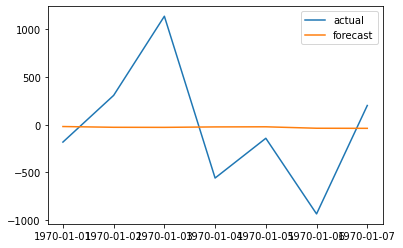

,actual,forecast
1970-01-01,-181.50,-18.293962
1970-01-02,308.50,-26.219618
1970-01-03,1139.00,-27.027710
1970-01-04,-558.75,-22.289007
1970-01-05,-141.50,-21.132877
1970-01-06,-935.25,-36.257168
1970-01-07,202.50,-37.211803


In [8]:
# make 1 week prediction
datelist_future = pd.date_range(dataset.index[-1], periods=7, freq="1d").tolist()

datelist_future_ = []
for date in datelist_future:
    datelist_future_.append(date.date())
    

predict_future = model.predict(x_train[-len(datelist_future_):], batch_size=1)
predict_future = scaler_predict.inverse_transform(predict_future)
y_train = scaler_predict.inverse_transform(y_train)

df = pd.DataFrame(np.concatenate([y_train[-len(datelist_future_):], predict_future], axis=1), columns=["actual", "forecast"]).set_index(pd.Series(datelist_future_))
error = mean_squared_error(df.actual, df.forecast)

print("\n")
print(f"LSTM MODEL")
print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(df.actual, df.forecast)}")

df.plot()
plt.show()

df

# MULTIVARIANT FORECAST WITH LSTM

In [17]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

def undo_scaling(y_pred, x_test, scaler_obj):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

def predict_df(unscaled_predictions, original_df, target_col, is_stationary):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-len(unscaled_predictions):].index)
    act_sales = list(original_df[-len(unscaled_predictions):][target_col])        
    
    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        
        if not is_stationary:
            result_dict['forecast'] = unscaled_predictions[index][0] + act_sales[index]
        else:
            result_dict['forecast'] = unscaled_predictions[index][0]
          
        result_dict[date] = sales_dates[index]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [19]:
is_stationary = stationary_df["is_stationary"].values[0]

def tts(data, target_col):
    data = data.drop([target_col, "is_stationary", "txn_date"],axis=1)
    train, test = data[0:-7].values, data[-7:].values
    
    
    return train, test

train, test = tts(stationary_df, target_col=target_col)
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add(LSTM(20, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.25))
model.add(Dense(150))
model.add(Dense(y_train.shape[1]))

weight_path = "test_119/weights.h5"
model_path = "test_119/"
mcp = ModelCheckpoint(filepath=weight_path, verbose=1, save_best_only=True, save_weights_only=True)


if not tf.io.gfile.exists(model_path):
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
else:
    model = tf.keras.models.load_model(model_path)
    model.load_weights(weight_path)

model.fit(X_train, y_train, epochs=800, batch_size=1, verbose=1, shuffle=False, validation_split=0.2, callbacks=[mcp, rlr])
model.save(model_path)

Epoch 1/800
43/48 [=========================>....] - ETA: 0s - loss: 0.0012   
Epoch 00001: val_loss improved from inf to 0.00138, saving model to test_119/weights.h5
48/48 [==============================] - 2s 44ms/step - loss: 0.0012 - val_loss: 0.0014 - lr: 3.3087e-26
Epoch 2/800
48/48 [==============================] - ETA: 0s - loss: 0.0015 
Epoch 00002: val_loss did not improve from 0.00138
48/48 [==============================] - 1s 11ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 3.3087e-26
Epoch 3/800
43/48 [=========================>....] - ETA: 0s - loss: 0.0030
Epoch 00003: val_loss did not improve from 0.00138
48/48 [==============================] - 1s 11ms/step - loss: 0.0027 - val_loss: 0.0014 - lr: 3.3087e-26
Epoch 4/800
48/48 [==============================] - ETA: 0s - loss: 0.0018
Epoch 00004: val_loss did not improve from 0.00138
48/48 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0014 - lr: 3.3087e-26
Epoch 5/800
43/48 [============



LSTM MODEL
MEAN SQUARE ERROR (MSE) 854.534
ROOT MEAN SQUARE ERROR (RMSE) 29.232
R2_SCORE (ACCURACY) 0.990


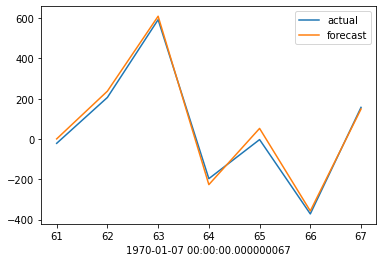

,actual,forecast
1970-01-07 00:00:00.000000067,,
61,-21.203213,0.805832
62,206.579743,237.811111
63,592.648611,609.709984
64,-196.572847,-226.186250
65,-2.608686,52.865079
66,-371.593833,-357.027547
67,157.304247,149.280451


In [20]:
predictions = model.predict(X_test, batch_size=1)
unscaled = undo_scaling(y_pred=predictions, x_test=X_test, scaler_obj=scaler)

imp_sales_data = stationary_df[["amount"]]


dates = predict_df(unscaled, imp_sales_data, target_col=target_col, is_stationary=is_stationary)[date]
y_test = undo_scaling(y_pred=y_test, x_test=X_test, scaler_obj=scaler)[:, 0]

df = pd.DataFrame(np.concatenate([y_test.reshape(-1, 1), unscaled[:, 0].reshape(-1, 1)], axis=1), columns=["actual", "forecast"]).set_index(pd.Series(dates))
error = mean_squared_error(df.actual, df.forecast)

print("\n")
print(f"LSTM MODEL")
print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(df.actual, df.forecast)}")

df.plot()
plt.show()

df